# Example 1: GAP 2017 Carbon 
## Tasks
 - Train energy, forces, and virials of [carbon](https://doi.org/10.1103/PhysRevB.95.094203).
 - Plot the properties calculated by HotPP vs DFT.
 - Use ASE Calculator interface.
 - Plot the phono spectrum. 

## Input 
You can see the following files required by this training task in this fold.

```bash
carbon
|- input.yaml               
|- model.ckpt
|- data/
   |- train.traj            
   |- test.traj             
```
- `model.ckpt` is a checkpoint of pre-trained model, we will continue our train from this to quickly reproduce the results.
- `train.traj` is the training data, it can be any format which can be red by `ase` if the `type` is `ase`. The target energy should be stored in `info['energy']` or can be got by `get_potential_energy()`, the target forces should be stored in `info['forces']` or can be got by `get_forces()`, the target virials should be stored in `info['virial']` (or `info['stress']`) or can be got by `get_stress()` , we will convert it to `virial` by multiple `-volume`.
- `test.traj` is the testset.
- [`input.yaml`](input.yaml) controls the specific details of model architecture and training. Some import parameters in this tasks are:

```yaml
cutoff: 3.0
Data:
  type: ase
  trainSet: data/train.traj 
  testSet: data/test.traj
Train:
  allowMissing: True
  targetProp: ["energy", "forces", "virial"] 
  weight: [0.5, 1.0, 0.2]
  maxEpoch: 10
```

These parameters mean the cutoff in this task is 3.0 Å. We use `data/train.traj` as trainset and `data/test/traj` as testset (actually it should be vaildation dataset here). We set `allowMissing` to `True` since only part of the structures has `virial` property. We train `energy`, `forces`, and `virial` in this task, and the weights are `0.5`, `1.0`, `0.2` respectively. And we just train 10 epoch from previously trained model since it is only an example. (It takes about 15 min on my computer with RTX 2070, you can decrease it to save time)

## Train
Now, we can train the model by:

In [12]:
! hotpp train --load_checkpoint model.ckpt

15:36:20                                                                       
          ____                        MiaoNet  
        ,'  , `.              (v.0.1.0 RELEASE ฅ^oωo^ ฅ)           ___     
     ,-+-,.' _ | ,--,   =====================================    ,--.'|_   
  ,-+-. ;   , |,--.'|                ,---.       ,---,           |  | :,'  
 ,--.'|'   |  ;|  |,                '   ,'\  ,-+-. /  |          :  : ' :  
|   |  ,', |  '`--'_      ,--.--.  /   /   |,--.'|'   |  ,---. .;__,'  /   
|   | /  | |  |,' ,'|    /       \.   ; ,. |   |  ,"' | /     \|  |   |    
'   | :  | :  |'  | |   .--.  .-. '   | |: |   | /  | |/    /  :__,'| :    
;   . |  ; |--'|  | :    \__\/: . '   | .; |   | |  | .    ' / | '  : |__  
|   : |  | ,   '  : |__  ," .--.; |   :    |   | |  |/'   ;   /| |  | '.'| 
|   : '  |/    |  | '.'|/  /  ,.  |\   \  /|   | |--' '   |  / | ;  :    ; 
;   | |`-'     ;  :    ;  :   .'   \`----' |   |/     |   :    | |  ,   /  
|   ;/         |  ,   /|  ,     .-./

You can also monitor the loss and learning rate curve by
```bash
$ tensorboard --logdir=outDir
```
during and after training.  
The epoch begin from 169 since the `model.ckpt` stop there, and the training end at 178 epoch because the `maxEpoch` is 10.

## Eval
After training done, we can evaluate the model.


In [13]:
%cd eval
! hotpp eval -m ../outDir/best.pt -d ../data/test.traj -p energy forces virial --device cuda -b 16

/home/gegejun/work/tpn/examples/carbon/eval
100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


This command means that we use `outDir/best.pt` to evaluate `energy`, `forces`, and `virial` of `data/test.traj` with `cuda`, and the `batchsize` is 16, then the target property and the predicted property are saved by `npy`, you can load them by:
```python
import numpy as np
n_atoms = np.load('n_atoms.npy')
e_dft = np.load('target_energy.npy')
e_hot = np.load('output_energy.npy')
```
And you can analyze them. To plot them to compare with DFT:

In [14]:
! hotpp plot -p per_energy forces per_virial

This command means that we plot `peratom energy`, `forces`, and `peratom virial` calculated by `HotPP` and the target values. And you can see the results:  

|`peratom energy`|`forces`|`peratom virial`|
|:-:|:-:|:-:|
|<img src="eval/per_energy.png" width = "300"  alt="perenergy" />|<img src="eval/forces.png" width = "300"  alt="forces" />|<img src="eval/per_virial.png" width = "300"  alt="pervirial" />|


If you need plot `energy` instead of `peratom energy`, just use:
```bash
$ hotpp plot -p energy
```

Then we introduce the usage of ASE Calculator interface. 
First, we freeze the model so you can use it in the environment just with `pytorch`, and do not require `hotpp` being installed.

In [16]:
! hotpp freeze ../outDir/best.pt

This command will give `ase-infer.pt` and `lammps-infer.pt`, we only need `ase-infer.pt` in this example.  
Copy the [ase interface file](../../interface/ase/hotase.py) to the current fold or add `the-path-to-hotase.py` to `PYTHONPATH` so you can imort `Calculator` from this file. And you can use it as an `Calculator` of `ase`.

In [25]:
%cp ../../../interface/ase/hotase.py .
from hotase import MiaoCalculator
from ase.build import bulk

atoms = bulk('C', 'diamond', cubic=True)
calc = MiaoCalculator("ase-infer.pt")
atoms.set_calculator(calc)
print(f"\nenergy:\n {atoms.get_potential_energy()}"
      f"\nforces:\n {atoms.get_forces()}"
      f"\nstress:\n {atoms.get_stress()}") 


energy:
 -1266.192365525202
forces:
 [[ 8.12880579e-16  5.87312317e-16  1.54343769e-14]
 [-6.93889390e-15 -5.44009282e-15 -1.43741232e-14]
 [-5.32814895e-15  1.65546830e-15  3.92698027e-16]
 [-1.38777878e-16 -5.32584490e-17 -7.21644966e-16]
 [-2.97773019e-15 -2.18976313e-15  5.55013934e-15]
 [ 1.09989150e-14 -4.85001579e-15  8.16734918e-15]
 [ 4.35870957e-15  3.54534110e-17 -5.88721780e-16]
 [-5.87283528e-16  1.04185866e-14 -1.42429471e-14]]
stress:
 [ 9.48110825e-02  9.48110825e-02  9.48110825e-02  2.44174316e-16
 -5.16629437e-16  3.12062878e-16]


We can also plot the phono spectrum of diamond with such `Calculator`. This task need `Phonopy`, install it by 
```bash
$ pip install phonopy
``` 
if required.

Copy the [phono calculator file](../../tools/phono.py) to the current fold or add `the-path-to-phono.py` to `PYTHONPATH` so you can imort functions from this file.

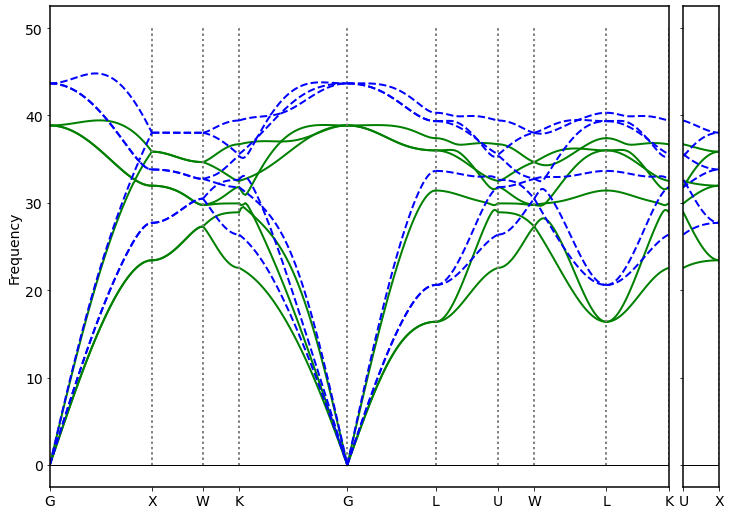

In [75]:
%cp ../../../tools/hotphono.py .
import hotphono
import numpy as np
from phonopy import Phonopy
from phonopy.interface.phonopy_yaml import PhonopyYaml
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid   

unitcell = hotphono.ase2phono(atoms)
supercell_matrix = np.array([2, 2, 2])
phonon = Phonopy(unitcell=unitcell, 
                 supercell_matrix=supercell_matrix,
                 # primitive_matrix=primitive_matrix,
                 primitive_matrix='auto')

force_constants = np.load("force_constant_dft.npy")
phonon.force_constants = force_constants
phpy_yaml = PhonopyYaml(settings={'force_sets': True,
                                  'displacements': True,
                                  'force_constants': True,
                                  'born_effective_charge': True,
                                  'dielectric_constant': True})
phpy_yaml.set_phonon_info(phonon)
atoms.info['phono_info'] = phpy_yaml._data
band_dict = hotphono.get_band_structure(phonon, atoms)
fig = plt.figure(figsize=(12, 10))
axs = ImageGrid(fig, 111, nrows_ncols=(1, len(band_dict['labels_path'])), axes_pad=0.2, label_mode="L")
#plot_band_structure(band_dict, axs, 'g')

force_constants = np.load("force_constant_dft.npy")
phonon.force_constants = force_constants
phpy_yaml = PhonopyYaml(settings={'force_sets': True,
                                  'displacements': True,
                                  'force_constants': True,
                                  'born_effective_charge': True,
                                  'dielectric_constant': True})
phpy_yaml.set_phonon_info(phonon)
atoms.info['phono_info'] = phpy_yaml._data
band_dict = hotphono.get_band_structure(phonon, atoms)
hotphono.plot_band_structure(band_dict, axs, 'green', max_freq=50)


force_constants = hotphono.get_force_constants(calc, phonon)
phonon.force_constants = force_constants
phpy_yaml = PhonopyYaml(settings={'force_sets': True,
                                  'displacements': True,
                                  'force_constants': True,
                                  'born_effective_charge': True,
                                  'dielectric_constant': True})
phpy_yaml.set_phonon_info(phonon)
atoms.info['phono_info'] = phpy_yaml._data
band_dict = hotphono.get_band_structure(phonon, atoms)
hotphono.plot_band_structure(band_dict, axs, 'blue', linestyle='--', max_freq=50)


plt.savefig('phono.pdf')
